# AutoML for Images - Fire Detection - Calling CV model Fire Detection on video

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/webcam.jpg?raw=true" width=600>

In [32]:
#!pip install moviepy

In [33]:
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
import requests
import json
import matplotlib.pyplot as plt 
import cv2
import os
import urllib
import time
import emoji
import moviepy
import moviepy.editor
import pymsteams
import smtplib
from email.message import EmailMessage
import glob

In [34]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


In [35]:
# MS Teams connection
teams="tobereplaced"

## 1. AutoML for Images computer vision model to use

In [36]:
service = Webservice(workspace=ws, name='automlfiredetection')
print(service.scoring_uri)
print(service.swagger_uri)

http://20.62.79.212:80/api/v1/service/automlfiredetection/score
http://20.62.79.212:80/api/v1/service/automlfiredetection/swagger.json


In [37]:
primary, secondary = service.get_keys()
scoring_uri = service.scoring_uri
key = primary

## 2. Image to analyze

In [38]:
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/testfire%20(1).jpg?raw=true'
#image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/testfire%20(2).jpg?raw=true'
#image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/testfire%20(3).jpg?raw=true'

image_file = 'tests/webcamtest.jpg'

Image information: tests/webcamtest.jpg  Height = 720 Width = 1280


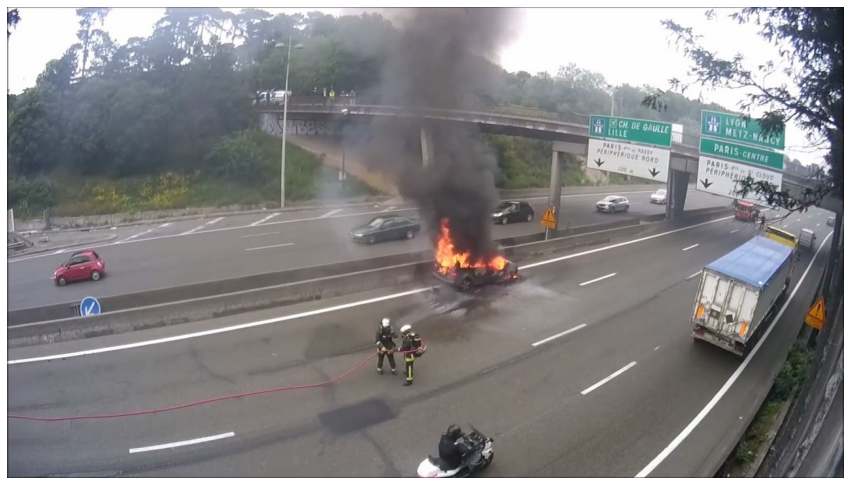

In [39]:
img = cv2.imread(image_file)
urllib.request.urlretrieve(image_url, filename=image_file)
h, w, c = img.shape
print("Image information:", image_file, " Height =", h, "Width =", w)

plt.figure(figsize=(15,15)) 
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image_rgb)

## 3. Results

In [40]:
input_data = open(image_file, 'rb').read()
headers = {'Content-Type': 'application/json'}
headers['Authorization'] = f'Bearer {key}'

resp = requests.post(scoring_uri, input_data, headers=headers)
print(resp.text)

{"filename": "/tmp/tmpl5faoah1", "probs": [1.0, 1.936540483526983e-09], "labels": ["Fire", "Non-Fire"]}



In [41]:
predictions = json.loads(resp.text) # Loading the predictions from the computer vision model    
probs = predictions['probs']
labels = predictions['labels']

if probs[0] >= probs[1]:
    max = 0
elif probs[0] < probs[1]:
    max = 1

print(predictions)
print()
print('\033[1;31;34m>> Prediction:', labels[max], 'with confidence =', round(probs[max], 3))

{'filename': '/tmp/tmpl5faoah1', 'probs': [1.0, 1.936540483526983e-09], 'labels': ['Fire', 'Non-Fire']}

>> Prediction: Fire with confidence = 1.0


## 4. Analyzing a video

In [42]:
videofile="videos/car_in_fire.mp4"

In [43]:
def convert(seconds):
    hours = seconds // 3600
    seconds %= 3600
    mins = seconds // 60
    seconds %= 60
    return hours, mins, seconds

video = moviepy.editor.VideoFileClip(videofile)
video_duration = int(video.duration)

hours, mins, secs = convert(video_duration)
duration=str(hours) +':' + str(mins) + ':' + str(secs)

data = cv2.VideoCapture(videofile)
frames = data.get(cv2.CAP_PROP_FRAME_COUNT)
fps = data.get(cv2.CAP_PROP_FPS)
vid = cv2.VideoCapture(videofile)
h = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
w = vid.get(cv2.CAP_PROP_FRAME_WIDTH)

print("Video information\n")
print("- Video Duration:", duration)
print("- Frames per second =", fps)
print("- Number of frames =", secs*fps)
print("- Height =", int(h), "Width =", int(w))

Video information

- Video Duration: 0:0:20
- Frames per second = 30.0
- Number of frames = 600.0
- Height = 1080 Width = 1920


In [44]:
from IPython.display import Video
Video(videofile, width=1024)

In [45]:
#os.mkdir('frames')

In [46]:
#os.mkdir('processed_frames')

In [47]:
# Delete previous captured images
!rm frames/*.jpg
!rm processed_frames/*.jpg

In [48]:
cap = cv2.VideoCapture(videofile)

ncount = 30  # for 30 at 30 fps, this advances 1 seconds
count = 0

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        import datetime
        dt = datetime.datetime.now()
        now = dt.strftime("%Y-%m-%d %H:%M:%S")
        capturefile = "frames/frame_" + str(count) + ".jpg"
        cv2.imwrite(capturefile, frame)
        count += ncount
        cap.set(1, count)    
    
        img = cv2.imread(capturefile)
        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        input_data = open(capturefile, 'rb').read()
        
        # Calling the CV model
        headers = {'Content-Type': 'application/json'}
        headers['Authorization'] = f'Bearer {key}'
        resp = requests.post(scoring_uri, input_data, headers=headers)
        predictions = json.loads(resp.text)
        probs = predictions['probs']
        labels = predictions['labels']
        
        if probs[0] >= probs[1]:
            max = 0
        elif probs[0] < probs[1]:
            max = 1

        if labels[max]=='Non-Fire':
            print(now, "Frame", count, "\t=> ", emoji.emojize(':thumbs_up:'), 
                  'No fire', '=', round(probs[max], 2))
            color4 = (0,255,0)
        
        if labels[max]=='Fire':
            print(now, "Frame", count, "\t=> ", emoji.emojize(':fire:'), 
                  '[Alert] Fire detected!', '=', round(probs[max], 2))
            color4 = (0,0,255)
            
            from datetime import datetime

            nowMSG = datetime.now()
            TeamsMSG = '[' + str(nowMSG) + '] ' + 'ALERT: Fire detected at frame ' \
                        + str(count) + ' with a confidence = ' + str(round(probs[max], 2))
            
            #print('Message to send to Teams:\n', TeamsMSG)
            myTeamsMessage = pymsteams.connectorcard(teams)
            myTeamsMessage.text(TeamsMSG)
            #myTeamsMessage.printme()
            myTeamsMessage.send()
        
        color1 = (0, 165, 255)
        color2 = (0, 165, 255)
        color3 = (0, 0, 255)
        currentdate = str(now)
        framenumber = "Frame " + str(count)
        
        if labels[max]=='Fire':
            texttodisplay='[Alert] Fire detected!' + ' = ' + str(round(probs[max], 2))
        
        if labels[max]=='Non-Fire':
            texttodisplay='No fire' + ' = ' + str(round(probs[max], 2))
        
        cv2.putText(img, currentdate, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color1, 6)
        cv2.putText(img, framenumber, (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color2, 6)
        cv2.putText(img, "CCTV cam 1", (1500, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color3, 4)
        cv2.putText(img, texttodisplay, (10, 220), cv2.FONT_HERSHEY_SIMPLEX, 3, color4, 10)
        
        if labels[max] == 'Fire':
            if count < 100 :
                count2='0' + str(count)
                savefile = "processed_frames/" + str(count2) + "_fire_pred_frame_" + str(round(probs[max], 3)) + ".jpg"
            if count >= 100 :
                savefile = "processed_frames/" + str(count) + "_fire_pred_frame_" + str(round(probs[max], 3)) + ".jpg"
            
        if labels[max] == 'Non-Fire':
            if count < 100 :
                count2='0' + str(count)
                savefile = "processed_frames/" + str(count2) + "_nonfire_pred_frame_" + str(round(probs[max], 3)) + ".jpg"
            if count >= 100 :    
                savefile = "processed_frames/" + str(count) + "_nonfire_pred_frame_" + str(round(probs[max], 3)) + ".jpg"

        cv2.imwrite(savefile, img)
    
    else:
        cap.release()
        break

2021-12-13 16:45:44 Frame 30 	=>  👍 No fire = 0.98
2021-12-13 16:45:45 Frame 60 	=>  👍 No fire = 0.78
2021-12-13 16:45:46 Frame 90 	=>  👍 No fire = 0.99
2021-12-13 16:45:47 Frame 120 	=>  👍 No fire = 0.99
2021-12-13 16:45:49 Frame 150 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:45:53 Frame 180 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:45:57 Frame 210 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:00 Frame 240 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:03 Frame 270 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:08 Frame 300 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:12 Frame 330 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:15 Frame 360 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:19 Frame 390 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:21 Frame 420 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:24 Frame 450 	=>  🔥 [Alert] Fire detected! = 1.0
2021-12-13 16:46:28 Frame 480 	=>  🔥 [Alert] Fire detected! = 1.0
202

## 5. Let's display some processed images

In [20]:
results_path = 'processed_frames/'

In [21]:
def viewimage(processed_image):
    imagetodisplay = results_path + processed_image
    img = cv2.imread(imagetodisplay)
    plt.figure(figsize=(20,15)) 
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)  

### Some Non Fire images

In [22]:
for root, directories, files in os.walk(results_path, topdown=False):
    nonfirelist=[]
    for name in files:
        if (name.__contains__("_nonfire_")):
            nonfirelist.append(name)

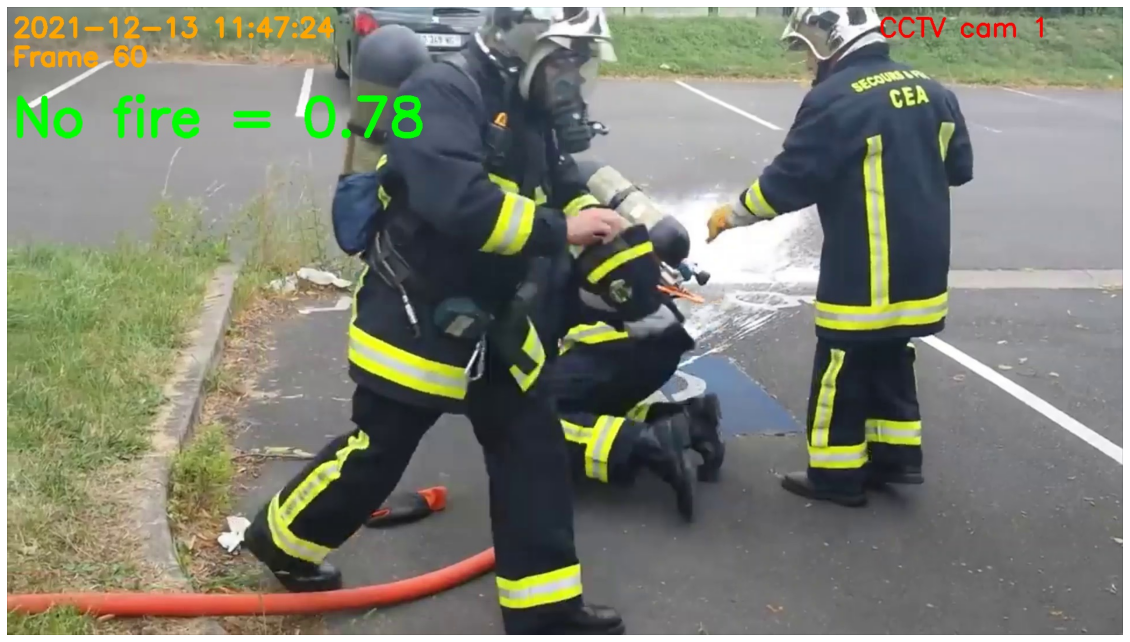

In [23]:
viewimage(nonfirelist[1])

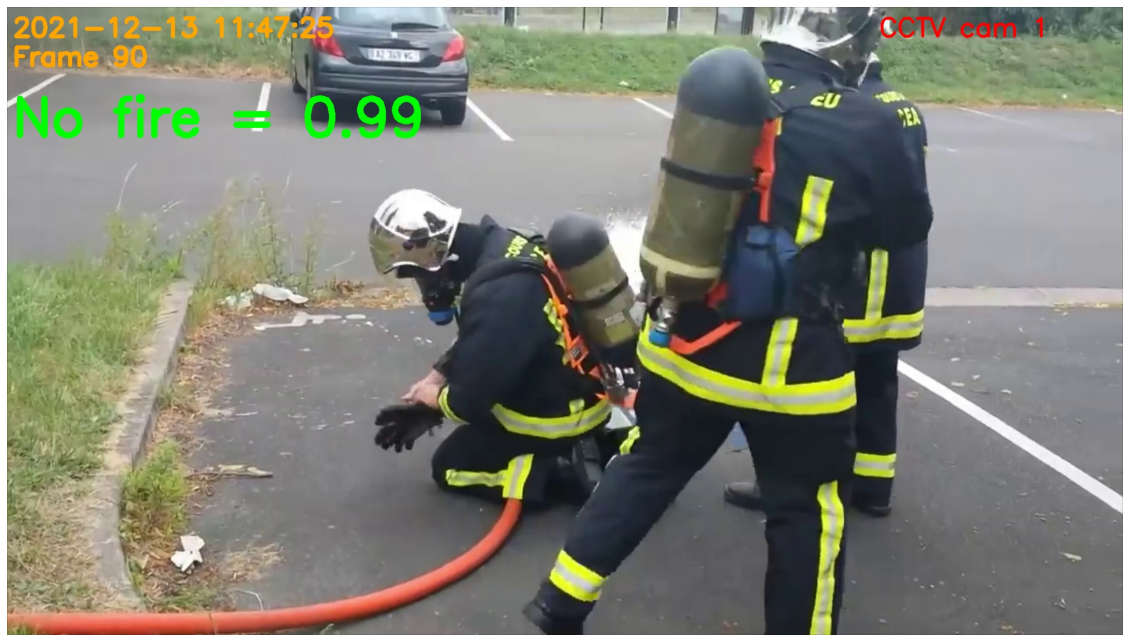

In [24]:
viewimage(nonfirelist[2])

### Fire images

In [25]:
for root, directories, files in os.walk(results_path, topdown=False):
    firelist=[]
    for name in files:
        if (name.__contains__("_fire_")):
            firelist.append(name)

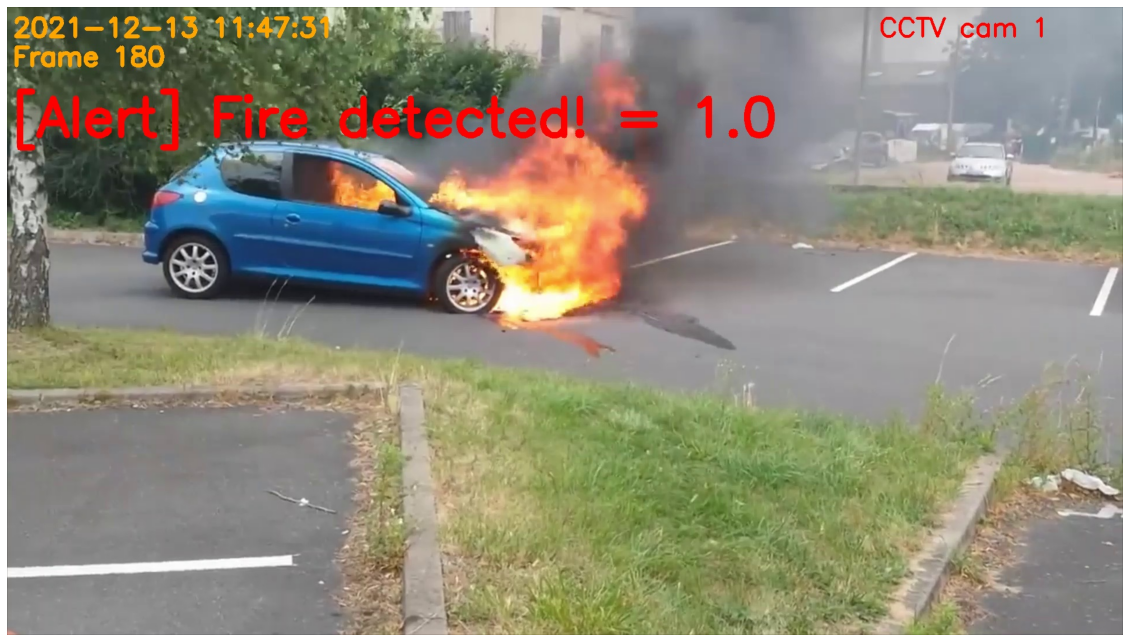

In [26]:
viewimage(firelist[1])

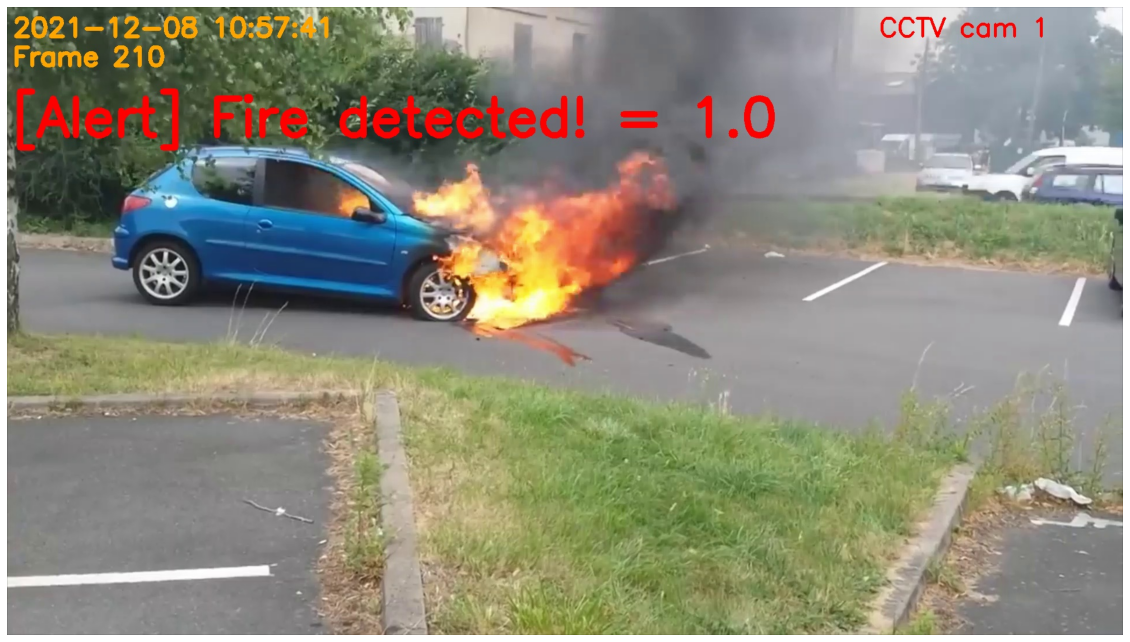

In [27]:
viewimage(firelist[2])

## 6. Saving video

In [27]:
video_output = 'videos/output_car_in_fire.avi'

print("Saving video:", video_output)
print("Processing...")

images = [img for img in os.listdir(results_path) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(results_path, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_output, 0, 1, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(results_path, image)))

video.release()
print(emoji.emojize(':thumbs_up:'), 'Done.')

Saving video: videos/output_car_in_fire.avi
Processing...
👍 Done.


In [28]:
!ls videos/output_car_in_fire.avi -lh

-rwxrwxrwx 1 root root 63M Dec 13 11:48 videos/output_car_in_fire.avi


## 7. Playing the video

In [29]:
from IPython.display import FileLink
video_link = FileLink(path=video_output)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AutoMLforImages/firedetection/videos/output_car_in_fire.avi

## 9. Sending Email

In [30]:
# Retrieve email parameters from email_parameters.py
import email_parameters as emailparams
EMAIL_SENDER = emailparams.EMAIL_SENDER
EMAIL_PASSWORD = emailparams.EMAIL_PASSWORD
EMAIL_RECEIVER = emailparams.EMAIL_RECEIVER

In [31]:
import datetime
emaildate = datetime.datetime.today().strftime ('%d-%b-%Y %H:%M:%S')

msg = EmailMessage()

msg['Subject'] = '[ALERT] Fire has been detected ' + str(emaildate)
msg['From'] = EMAIL_SENDER 
msg['To'] = EMAIL_RECEIVER 

MSG = "Fire has been detected!\n" + "\nVideo link: " + str(video_link)
msg.set_content(MSG)

attachedfile1 = 'processed_frames/' + firelist[1] # 1st image with fire detection

with open(attachedfile1, 'rb') as pdf:
    msg.add_attachment(pdf.read(), maintype='application', subtype='octet-stream', filename=pdf.name)
    
with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
    print(emaildate, "Sending email...")
    smtp.login(EMAIL_SENDER, EMAIL_PASSWORD) 
    smtp.send_message(msg)
    print(emoji.emojize(':thumbs_up:'), 'Done.')

13-Dec-2021 11:49:10 Sending email...
👍 Done.


> End